# FlowPic replication

For the course of this exploration I'll be attempting to replicate salient aspects of [FlowPic: Encrypted Internet Traffic Classification is as Easy as Image Recognition](https://ieeexplore.ieee.org/document/8845315) by Tal Shapira and Yuval Shavitt.

Jump to:
1. [Preprocessing](#Preprocessing)
1. [Classifier](#Classifier)
1. [Adding direction as a channel](#Adding-direction-as-a-channel)
1. [Predicting](#Predicting)
1. [Old Code](#Old-Code)

In [1]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import ipaddress
from ipaddress import ip_address as IP

import tensorflow as tf
from tensorflow import keras

# Preprocessing

## Dataset preparations

> We split each pcap file to unidirectional flows,  where  each  flow  is  defined  by  a  5-tuple  {source  IP,source port, destination IP, destination port, protocol}

This suggests the following process/changes to our preprocessing:
- Packet level unbinning should produce multiple dataframes
- Each dataframe needs to have a unique pair of IPs, *direction*, etc.
    - Since we're assuming a VPN is in use, we should be able to clean the data so that only the VPN traffic remains, then we can just split it on direction

In [2]:
raw_files = glob.glob('../data/raw/*youtube*-vpn*')
f = np.random.choice(raw_files)
# f = '../data/raw/stdoan-youtube[720p60]-1x-vpn-windows-clean-20201102.csv'
print(f)
df_raw = pd.read_csv(f)
df = src.data.clean(df_raw)
print(df.IP1.unique(), df.IP2.unique())
df

../data/raw/stdoan-youtube[2160p60]-1x-vpn-windows-20201102.csv
['2607:F720:1901:1691:137:110:35:169' '137.110.35.169'] ['2607:F8B0:4007:80E::200E' '2607:F8B0:401C:1::9'
 '2607:F8B0:4007:803::2003' '132.239.0.252' '2607:F8B0:4007:80E::2003'
 '2607:F8B0:4007:804::200E' '2607:F8B0:4007:800::2016'
 '2607:F8B0:4007:813::2003' '2607:F8B0:4007:816::200A'
 '2607:F8B0:4007:80F::200E' '2607:F8B0:4007:801::200A'
 '2607:F8B0:4007:801::200E' '2607:F8B0:4023:C03::BC'
 '2607:F8B0:4007:813::2004' '2607:F8B0:4007:810::200E'
 '2607:F8B0:4007:80C::2001' '52.167.253.237' '2404:6800:4005:804::2003'
 '132.239.0.250' '2607:F720:1901:1691:137:110:35:169'
 '2A00:1450:4007:6::8' '106.13.184.7' '2607:F8B0:4007:2E::C'
 '2607:F8B0:4023:C03::64' '2607:F8B0:4007:811::200E'
 '2607:F8B0:4007:80D::200A' '185.199.110.153' '2607:F8B0:4007:80D::200E'
 '2607:F8B0:4007:808::2003' '23.65.34.215' '2607:F8B0:4007:80B::200A'
 '2600:1406:3400::173F:F343' '52.109.12.18' '2607:F8B0:4007:813::200A'
 '2607:F8B0:4007:801::2003']


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1604368805,2607:F720:1901:1691:137:110:35:169,1271,2607:F8B0:4007:80E::200E,443,6,1041,17595,11,19,1604368805709;1604368805709;1604368805736;1604...,402;99;60;60;99;60;432;1280;60;1280;1280;60;12...,1;1;2;2;2;1;2;2;1;2;2;1;2;2;1;2;2;1;2;2;1;2;2;...
1,1604368806,2607:F720:1901:1691:137:110:35:169,1271,2607:F8B0:4007:80E::200E,443,6,2859,112016,47,93,1604368806198;1604368806198;1604368806198;1604...,1280;1280;60;1280;1280;60;1280;1280;60;1280;12...,2;2;1;2;2;1;2;2;1;2;2;1;2;2;1;2;2;1;2;2;1;2;2;...
2,1604368806,2607:F720:1901:1691:137:110:35:169,1462,2607:F8B0:401C:1::9,443,6,4224,76303,36,63,1604368806415;1604368806441;1604368806441;1604...,72;72;60;577;60;1280;1280;60;1195;124;1300;291...,1;2;1;1;2;2;2;1;2;1;1;1;2;2;2;1;2;2;1;2;2;1;2;...
3,1604368806,2607:F720:1901:1691:137:110:35:169,1463,2607:F8B0:401C:1::9,443,6,47839,1064582,635,842,1604368806415;1604368806446;1604368806446;1604...,72;72;60;577;60;1280;1280;60;1195;124;1300;398...,1;2;1;1;2;2;2;1;2;1;1;1;2;2;2;1;2;2;1;2;2;1;2;...
4,1604368806,2607:F720:1901:1691:137:110:35:169,1279,2607:F8B0:4007:803::2003,443,6,1667,654,7,8,1604368806530;1604368806530;1604368806530;1604...,128;99;1126;60;60;60;99;125;60;91;99;60;99;95;60;,1;1;1;2;2;2;2;2;1;2;2;1;1;1;2;
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1604369107,2607:F720:1901:1691:137:110:35:169,1471,2404:6800:4005:804::2003,443,6,120,236,2,3,1604369107347;1604369107347;1604369107347;1604...,116;60;60;60;60;,2;2;1;1;2;
344,1604369108,2607:F720:1901:1691:137:110:35:169,1571,2607:F8B0:4007:804::200E,443,6,61,72,1,1,1604369108673;1604369108699;,61;72;,1;2;
345,1604369109,2607:F720:1901:1691:137:110:35:169,1572,2607:F8B0:4007:813::200A,443,6,61,72,1,1,1604369109155;1604369109182;,61;72;,1;2;
346,1604369112,2607:F720:1901:1691:137:110:35:169,1271,2607:F8B0:4007:80E::200E,443,6,884,600,5,7,1604369112385;1604369112385;1604369112412;1604...,566;99;60;60;99;131;60;91;99;60;99;60;,1;1;2;2;2;2;1;2;2;1;1;2;


The cleaning isn't perfect. May need to revisit.

- Sometimes there are lots of 260x:x IPv6 communications, with many different addresses -- but they seem to be very important and contain the bulk of the packets. (See stdoan files)
- Sometimes there are communications where the VPN IP is in column 1 -- this should be addressed by splitting by direction... but also needs splitting by IP if we're going to split by direction...
- Sometimes there are *tons* of communications with "Shared Address Space" IPs -- again making there be *tons* of IPs that (I think) are truly contibuting to the same flow. (See arv020 files)
- Often there are non-vpn IPs that are still included

## Data Augmentation

> we  divide  each  unidirectional  flow  to  60  seconds  blocks

In [3]:
chunks = src.data.preprocess(
    df, chunk_length='60s',
    isolate_flow=False,
    split_directions=False
)
chunks[0]

Port1  \
IP1                                IP2                      packet_dirs          
2607:F720:1901:1691:137:110:35:169 2607:F8B0:4007:80E::200E 1             1271   
                                                            1             1271   
                                                            2             1271   
                                                            2             1271   
                                                            2             1271   
...                                                                        ...   
                                   2607:F8B0:401C:1::9      2             1463   
137.110.35.169                     106.13.184.7             2            18092   
2607:F720:1901:1691:137:110:35:169 2607:F8B0:4007:804::200E 1             1448   
                                   2607:F8B0:4007:816::200A 1             1450   
                                                            2             1450   

                                                                         Port2  \
IP1                                IP2                      packet_dirs          
2607:F720:1901:1691:137:110:35:169 2607:F8B0:4007:80E::200E 1              443   
                                                            1              443   
                                                            2              443   
                                                            2              443   
                                                            2              443   
...                                                                        ...   
                                   2607:F8B0:401C:1::9      2              443   
137.110.35.169                     106.13.184.7             2            58451   
2607:F720:1901:1691:137:110:35:169 2607:F8B0:4007:804::200E 1              443   
                                   2607:F8B0:4007:816::200A 1              443   
                                                            2              443   

                                                                         Proto  \
IP1                                IP2                      packet_dirs          
2607:F720:1901:1691:137:110:35:169 2607:F8B0:4007:80E::200E 1                6   
                                                            1                6   
                                                            2                6   
                                                            2                6   
                                                            2                6   
...                                                                        ...   
                                   2607:F8B0:401C:1::9      2                6   
137.110.35.169                     106.13.184.7             2                6   
2607:F720:1901:1691:137:110:35:169 2607:F8B0:4007:804::200E 1                6   
                                   2607:F8B0:4007:816::200A 1                6   
                                                            2                6   

                                                                          packet_times  \
IP1                                IP2                      packet_dirs                  
2607:F720:1901:1691:137:110:35:169 2607:F8B0:4007:80E::200E 1            1604368805709   
                                                            1            1604368805709   
                                                            2            1604368805736   
                                                            2            1604368805740   
                                                            2            1604368805740   
...                                                                                ...   
                                   2607:F8B0:401C:1::9      2            1604368855985   
137.110.35.169                     106.13.184.7             2 

## FlowPic Construction

> {IP packet size, time of arrival}

> At the first stage, we plot all record  pairs by  defining  our  X-axis  as  the  packet  arrival time, and  Y-axis  as  the  packet  size.

> An  absolute  majority  of the  packet  sizes  do  not  cross  the  1500  bytes  (which  is  the Ethernet MTU value), thus we disregard all packets with size greater  than  1500  (less  than  5%  of  all  packets),  and  limit our  Y-axis to  be  between 1  to  1500.

> For  the  X-axis, first  we normalize  all  time  of  arrival  values  by  subtracting  the  time of  arrival  of  the  first  packet  in  the  flow.  For  simplicity,  we set the 2D-histogram to be a square image. For this purpose, we  normalized  all  time  of  arrival  values  to  be  between  0 to  1500  (namely,  60  seconds  is  mapped  to  1500).

In [4]:
h = src.features.flowpic(chunks[0])

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='Normalized arrival time', ylabel='Packet size (bytes)'>)

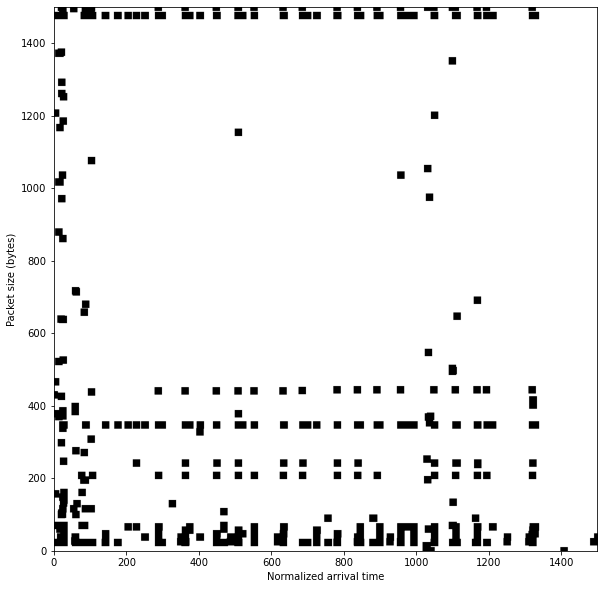

In [5]:
src.charts.flowpic(h, pixel_growth=10)

## All wrapped up

In [6]:
def random_flowpic(pattern='../data/raw/*-vpn-*', direction=None):
    """
    Direction {0: uploading, 1: downloading, None: both}
    """
    f = np.random.choice(glob.glob(pattern))
    df = pd.read_csv(f)
    clean = src.data.clean(df)
    if direction is not None:
        chunks = src.data.preprocess(clean, split_directions=True)[direction]
    else:
        chunks = src.data.preprocess(clean)

    hist = src.features.flowpic(chunks[-1])
    
    fig, ax = src.charts.flowpic(hist)
    
    fig.suptitle(f, fontsize=16)
    fig.tight_layout()
    
    return chunks, hist

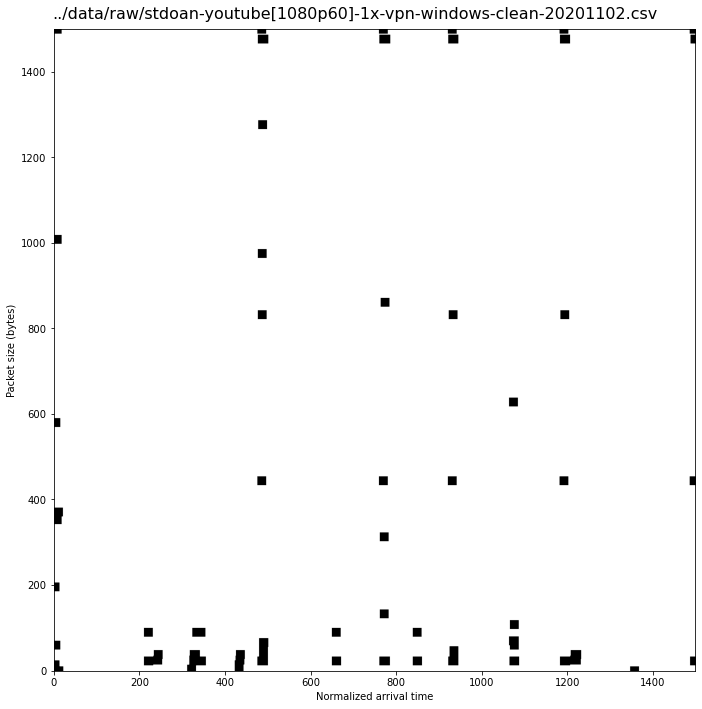

In [9]:
c, h = random_flowpic('../data/raw/stdoan*youtube*-vpn-*1102.csv', direction=None)

Very possible there are still just some un-clean data in our repository.

I'm getting a bit suspicious of the stdoan files.

## Possible extension

We could add a color chanel to our data for direction. That way we don't need to get rid of a direction entirely, but can still include it as a feature.

# Adding direction as a channel

In [1]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
# Load in a preprocessed file -- let's see what we're working with
f = np.random.choice(glob.glob('../data/preprocessed/*'))
print(f)
df = pd.read_csv(f)
df.head()

../data/preprocessed/browsing-33-pgaddiso-novideo-vpn-linux-20201116.csv


,IP1,IP2,packet_dirs,packet_times,packet_sizes
0,10.0.0.236,137.110.0.70,2,1605597575404,295
1,10.0.0.236,137.110.0.70,1,1605597575405,138
2,10.0.0.236,137.110.0.70,1,1605597575419,562
3,10.0.0.236,137.110.0.70,2,1605597575441,194
4,10.0.0.236,137.110.0.70,1,1605597575482,118


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2ed66ce650>)

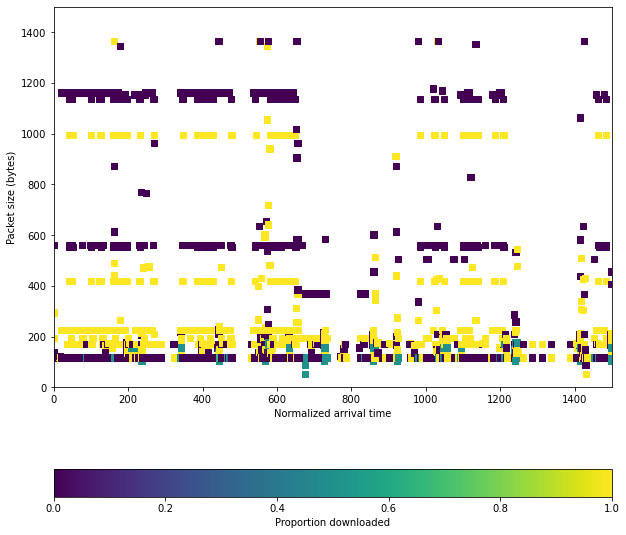

In [3]:
c = df[['packet_dirs', 'packet_times', 'packet_sizes']]

c = c[c.packet_sizes <= 1500]
c.packet_times = c.packet_times - c.packet_times.min()
c.packet_times = c.packet_times / c.packet_times.max() * 1500

bins=1500
binrange = [[0, 1500], [0, 1500]]
hist = np.histogram2d(c.packet_times, c.packet_sizes, bins=bins, range=binrange)
h = hist[0]
h = h / h.max()

# For each bin we want to calculate the proportion of packets that were down-
# loaded. A 1.0 means all packets in that bin were downloaded packets, and 0.0
# means all packets in that bin were uploaded.
cut_bins = np.arange(1500)
timebins = np.searchsorted(cut_bins, c.packet_times, side='right') - 1
sizebins = np.digitize(c.packet_sizes, cut_bins, right=False) - 1
c['bin'] = list(zip(timebins, sizebins))
c.packet_dirs = c.packet_dirs - 1
download_props = c.groupby('bin').packet_dirs.mean()
prop_bins = download_props.index.values

# Start off with a 'grey' channel -- all values are equally up- and downloaded.
download_channel = np.full((1500,1500), 0.5)
# Then fill in the calculated values from above
download_channel[list(zip(*prop_bins))] = download_props.values
dc = download_channel

flowpic = np.dstack([h, dc])

src.charts.flowpic(flowpic)

In [5]:
flowpic.shape

(1500, 1500, 2)

# Classifier

In [6]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import numpy as np
import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras

Need to load in the data.

In [20]:
INPUT_SHAPE = (1500,1500,1)

def data_generator(file_list, batch_size):
    """
    
    See:
    https://biswajitsahoo1111.github.io/post/reading-multiple-files-in-tensorflow-2/

    """
    i = 0
    while True:
        if i*batch_size >= len(file_list):
            i = 0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size] 
            data = []
            labels = []
            for file in file_chunk:
                # Only take the first n dimensions based on the input shape
                arr = np.load(file)[:,:,:INPUT_SHAPE[2]]
                data.append(arr.reshape(INPUT_SHAPE))
                labels.append(os.path.dirname(file).endswith(b'streaming'))
            data = np.asarray(data).reshape(-1,*INPUT_SHAPE)
            labels = np.asarray(labels)
            yield data, labels
            i = i + 1

def get_dataset(file_list, batch_size=10):
    dataset = tf.data.Dataset.from_generator(
        data_generator, args=(file_list, batch_size),
        output_types=(tf.float32, tf.bool),
        output_shapes=((None, *INPUT_SHAPE), (None,))
    )
    return dataset


batch_size = 50
all_files = glob.glob('../data/features/*/*.npy')
all_files = np.random.permutation(all_files)

from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(all_files, test_size=0.2)

train = get_dataset(train_files, batch_size)
valid = get_dataset(val_files, batch_size)

Now it's time to build the model.

> Our  LeNet-5  style  architecture comprises  seven  layers,  not  counting  the  input,  where  the ReLU activation function [25] is applied to the output of every convolutional and fully-connected layer.

> Our input is a 2-dimensional 1500x1500 matrix (pixel image).

> The first layer is a 2-dimensional convolutional layer (labeled as  CONV1)  with  10  filters  of  size  10x10  with  a  stride  of 5

> The outputs of  CONV1  are  10  feature  maps  of  size  300x300.

> The next layer is the first max-pooling layer with 10 feature maps of size 150x150, where each unit in each feature map is connected to a 2x2 neighborhood in the corresponding feature map  in  CONV1.

> Layer  CONV2  is  the  second  convolutional layer with 20 filters of size 10x10 with a stride of 5

> The  next  layer is  the  second  2x2  max-pooling  layer  results  with  20  feature maps of size 15x15.

> The next layer is a standard flatten layer that converts the 20 feature maps to a one dimensional layer of size 4500.

> Our next layer is a fully-connected layer of size 64.

> Finally,  our  output  layer  is  the  softmax  layer  whose  size depends  on  the  number  of  classes  in  each  sub-problem.

> In  our  CNN  (Figure  3),  we  use dropout  with  a  probability  of  0.25  in  CONV2  and  dropout with a probability of 0.5 in the fully-connected layer.

> The training was done by optimizing the categorical crossentropy cost function

> For  the  optimization  process  we  use  the Adam gradient-based optimizer

In [21]:
from tensorflow.keras import models, layers

model = models.Sequential()
# Args: filters, kernel_size, strides
model.add(layers.Conv2D(10, (10,10), (5,5), activation='relu', input_shape=INPUT_SHAPE))
# Args: pool_size, strides (defaults to pool)
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(20, (10,10), (5,5), activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
# Binary classification, turn into probabilities
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 299, 299, 10)      2010      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 10)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 20)        20020     
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [22]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
def steps_per_epoch(file_list, batch_size):
    return np.int(np.ceil(len(file_list) / batch_size))

history = model.fit(
    train, steps_per_epoch=steps_per_epoch(train_files, batch_size),
    validation_data=valid, validation_steps=steps_per_epoch(val_files, batch_size),
    epochs=3
)

Epoch 1/3
13/13 [==============================] - 102s 8s/step - loss: 0.6935 - acc: 0.5550 - val_loss: 0.6935 - val_acc: 0.4248
Epoch 2/3
13/13 [==============================] - 104s 8s/step - loss: 0.6951 - acc: 0.5156 - val_loss: 0.6935 - val_acc: 0.4248
Epoch 3/3
13/13 [==============================] - 102s 8s/step - loss: 0.6935 - acc: 0.5156 - val_loss: 0.6940 - val_acc: 0.4248


In [51]:
flowpic[:,:,[1,0]].shape

(1500, 1500, 2)

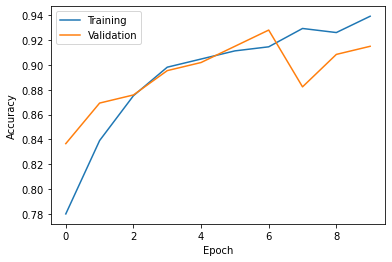

In [23]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [25]:
history.model.save('../data/out/model-notebook.h5')

# Predicting

In [1]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras

In [64]:
model = keras.models.load_model('../data/out/model-histonly.h5')

In [65]:
model.summary()

Model: "FlowPic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 10)      1010      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 20)        20020     
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3920)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2509

In [66]:
files = glob.glob('../data/features/*/*.npy')
dataset, steps = src.models.ingesting.get_dataset(glob.glob('../data/features/*/*.npy'), 32, [0], True)

In [67]:
preds = np.squeeze(model.predict(dataset, steps=steps))

In [68]:
labels = np.array([f.split('/')[3] == 'streaming' for f in files])

In [75]:
preds = np.squeeze(preds)
preds

array([0.43341058, 0.31813556, 0.46655786, 0.27662924, 0.17269   ,
       0.18375123, 0.4898428 , 0.2529453 , 0.46203542, 0.41403547,
       0.522194  , 0.33685064, 0.14106748, 0.56052655, 0.26605582,
       0.08339578, 0.49995652, 0.2002038 , 0.532538  , 0.42504525,
       0.45758593, 0.28154796, 0.44800082, 0.55136573, 0.23414421,
       0.19573152, 0.2617466 , 0.435551  , 0.46040285, 0.4999516 ,
       0.23983124, 0.38232058, 0.25444084, 0.46490043, 0.22213528,
       0.33564925, 0.22685108, 0.2180219 , 0.48160392, 0.12279952,
       0.48701483, 0.49619448, 0.43087807, 0.25477058, 0.47504926,
       0.15958977, 0.50250417, 0.22972456, 0.24857165, 0.33808133,
       0.23069656, 0.22683442, 0.4207081 , 0.48945767, 0.25088984,
       0.4792679 , 0.3108809 , 0.17760772, 0.23629525, 0.5801946 ,
       0.36961597, 0.4280338 , 0.24612167, 0.50491416, 0.2609008 ,
       0.45372793, 0.24212295, 0.2114672 , 0.37158263, 0.18204516,
       0.17307311, 0.3113926 , 0.14053077, 0.46978116, 0.33365

In [76]:
p = preds > 0.5

In [78]:
(p == labels).mean()

0.8740157480314961

Text(0.5, 1.0, 'Predicted Streaming Probabilities')

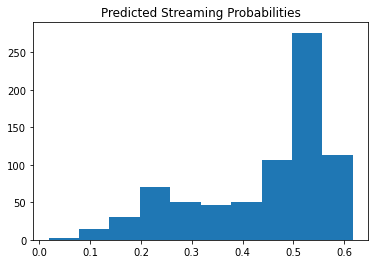

In [80]:
plt.hist(preds)
plt.title('Predicted Streaming Probabilities')

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

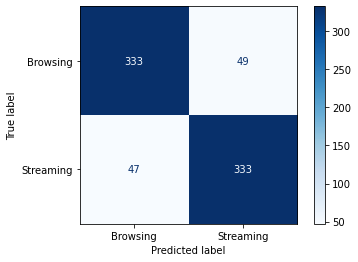

In [118]:
cmd = ConfusionMatrixDisplay(confusion_matrix(labels, p), ['Browsing', 'Streaming'])
cmd.plot(values_format='d', cmap='Blues')

In [88]:
wherediff = np.squeeze(np.argwhere(p != labels))

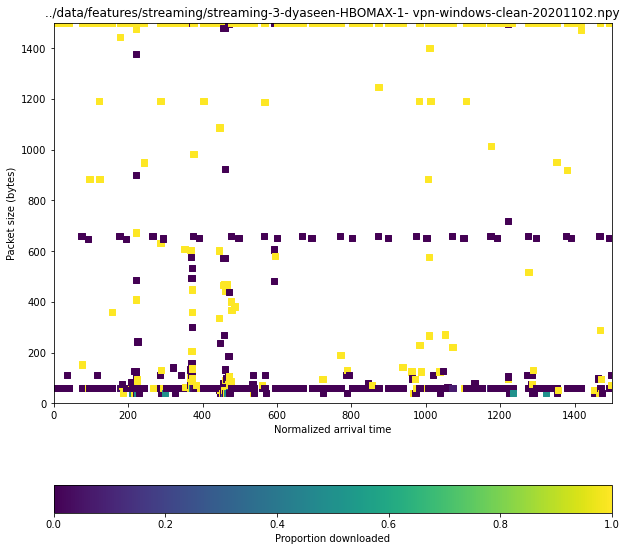

In [105]:
f = files[np.squeeze(wherediff)[93]]
a = np.load(f)
src.charts.flowpic(a)
plt.title(f);

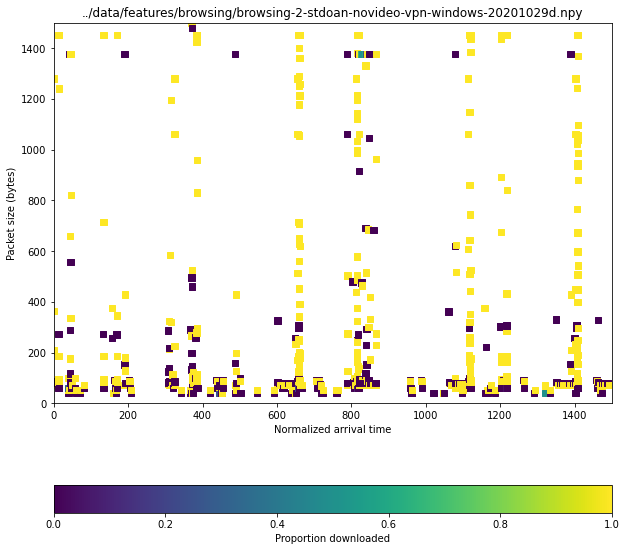

In [56]:
f = np.random.choice(files)
flowpic = np.load(f)
fig, ax = src.charts.flowpic(flowpic)
ax.set_title(f);

---
# Old Code

In [8]:
def unbin_packets(df):
    """
    """
    
    df = df.drop(columns=[
        'Time', '1->2Bytes', '2->1Bytes', '1->2Pkts', '2->1Pkts'
    ])
    
    packet_cols = ['packet_times', 'packet_sizes', 'packet_dirs']
#     packetlist_cols = [s.rstrip('s') for s in packet_cols]
    
    # Convert the strings `val1;val2;` into lists `[val1, val2]`
    df[packet_cols] = (
        df.loc[:,packet_cols]
        .apply(lambda ser: ser.str.split(';').str[:-1])
    )
    
    # 'Explode' the lists so each element gets its own row.
    exploded = (
        df
        .apply(
            lambda ser: ser.explode().astype(int) if ser.name in packet_cols else ser
        )
    )
    
    return exploded

In [142]:
unbinned = unbin_packets(df)

Perhaps if a particular flow constitutes more than x% of the unbinned data then we should single it out?

In [143]:
from functools import reduce

def dominating_flow(df, threshold=0.9):
    
    ip1_props = df.IP1.value_counts(normalize=True)
    ip2_props = df.IP2.value_counts(normalize=True)
    
    masks = []
    
    if ip1_props[0] > threshold:
        masks.append(
            df.IP1 == ip1_props.index[0]
        )
        
    if ip2_props[0] > threshold:
        masks.append(
            df.IP2 == ip2_props.index[0]
        )
        
    if masks:
        return df[reduce(lambda x, y: y & x, masks, True)]
    else:
        return df

In [144]:
dom = dominating_flow(unbinned)
dom

,IP1,Port1,IP2,Port2,Proto,packet_times,packet_sizes,packet_dirs
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149801,106,2
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149804,151,2
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149804,235,2
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149805,106,1
0,10.0.0.236,50074,137.110.0.69,443,17,1605151149806,106,2
...,...,...,...,...,...,...,...,...
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731137,171,2
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731138,118,1
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731406,172,1
9279,10.0.0.236,50074,137.110.0.69,443,17,1605154731498,174,2


Let's split up by ip pairs and direction.

Afterwards, if our data had a bunch of IPs, we can chuck out dataframes that are too small or something like that.

In [145]:
keys = ['IP1', 'IP2', 'packet_dirs']

indexed = (
    dom
    .sort_values(keys)
    .set_index(keys)
)
indexed

Port1  Port2  Proto   packet_times  \
IP1        IP2          packet_dirs                                       
10.0.0.236 137.110.0.69 1            50074    443     17  1605151149805   
                        1            50074    443     17  1605151149809   
                        1            50074    443     17  1605151149817   
                        1            50074    443     17  1605151149818   
                        1            50074    443     17  1605151149818   
...                                    ...    ...    ...            ...   
                        2            50074    443     17  1605154730618   
                        2            50074    443     17  1605154730629   
                        2            50074    443     17  1605154730629   
                        2            50074    443     17  1605154731137   
                        2            50074    443     17  1605154731498   

                                     packet_sizes  
IP1        IP2          packet_dirs                
10.0.0.236 137.110.0.69 1                     106  
                        1                     106  
                        1                     106  
                        1                     146  
                        1                     146  
...                                           ...  
                        2                     138  
                        2                     495  
                        2                     191  
                        2                     171  
                        2                     174  

[61196 rows x 5 columns]

In [146]:
indexed.index.value_counts(normalize=True)

(10.0.0.236, 137.110.0.69, 2)    0.520737
(10.0.0.236, 137.110.0.69, 1)    0.479263
dtype: float64

Just looked at a file with tons of the 260x IPs... I don't know how to deal with those.

For the moment might just chuck out dataframes that don't boil down to two index levels.

In [147]:
assert max(indexed.index.levshape) == 2, f"Couldn't determine a single main flow from the data! {indexed.index.levshape}"

In [148]:
fidx = indexed.index.unique()

download_idx = np.argwhere(fidx.levels[2] == 2)[0][0]

down = indexed.loc[fidx[download_idx]]
up = indexed.loc[fidx[1-download_idx]]

In [149]:
def chunk(df, chunk_length='60s'):
    """
    Returns a list of DataFrames, each `chunk_length` long in duration.
    """
    
    df_time = df.assign(timestamp=pd.to_datetime(df.packet_times, unit='ms'))
    # Important that we specify `origin='start'`, otherwise specifying a minute
    # will create chunks at e.g. 5:01, 5:02, ..., when we want to just take
    # 60s from the very first observation
    resampled = df_time.resample(chunk_length, on='timestamp', origin='start')

    chunks = []
    for (timestamp, frame) in resampled:
        chunks.append(frame)

    # Get rid of last chunk if it's incomplete
    last = chunks[-1]
    if last.timestamp.max() - last.timestamp.min() < pd.Timedelta(chunk_length):
        chunks.pop()

    return chunks

In [150]:
chunks = chunk(down)
chunks[0]

Port1  Port2  Proto   packet_times  \
IP1        IP2          packet_dirs                                       
10.0.0.236 137.110.0.69 2            50074    443     17  1605151149801   
                        2            50074    443     17  1605151149804   
                        2            50074    443     17  1605151149804   
                        2            50074    443     17  1605151149806   
                        2            50074    443     17  1605151149809   
...                                    ...    ...    ...            ...   
                        2            50074    443     17  1605151209438   
                        2            36720    443      6  1605151209674   
                        2            36720    443      6  1605151209674   
                        2            36720    443      6  1605151209674   
                        2            36720    443      6  1605151209695   

                                     packet_sizes               timestamp  
IP1        IP2          packet_dirs                                        
10.0.0.236 137.110.0.69 2                     106 2020-11-12 03:19:09.801  
                        2                     151 2020-11-12 03:19:09.804  
                        2                     235 2020-11-12 03:19:09.804  
                        2                     106 2020-11-12 03:19:09.806  
                        2                     151 2020-11-12 03:19:09.809  
...                                           ...                     ...  
                        2                     213 2020-11-12 03:20:09.438  
                        2                      52 2020-11-12 03:20:09.674  
                        2                      52 2020-11-12 03:20:09.674  
                        2                      89 2020-11-12 03:20:09.674  
                        2                      52 2020-11-12 03:20:09.695  

[640 rows x 6 columns]

In [151]:
def flowpic(chunk, bins=1500, draw=False, draw_binary=False):
    
    c = chunk[['packet_times', 'packet_sizes']]

    c = c[c.packet_sizes <= 1500]
    c.packet_times = c.packet_times - c.packet_times.min()
    c.packet_times = c.packet_times / c.packet_times.max() * 1500
    
    h = np.histogram2d(c.packet_times, c.packet_sizes, bins=bins)[0]
    h = h / h.max()
    
    if draw:
        options = {'cmap': 'Greys', 'origin': 'lower', 'vmin': 0, 'vmax': 1}
        if draw_binary:
            plt.imshow(h.T > 0, **options)
        else:
            plt.imshow(h.T, **options)
        plt.xlabel('Normalized arrival time')
        plt.ylabel('Packet size (bytes)')

    return h

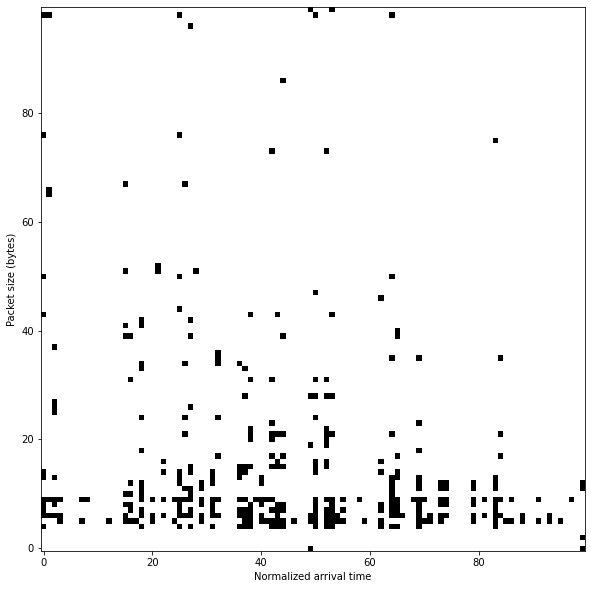

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))
h = flowpic(chunks[0], bins=100, draw=True, draw_binary=True)

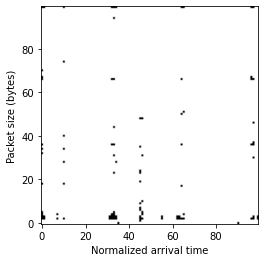

In [138]:
flowpic(chunk(unbinned)[1], 100, True, True);


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



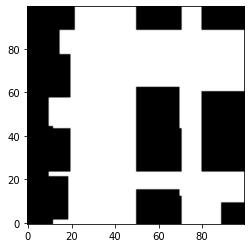

In [139]:
options = {'cmap': 'Greys', 'origin': 'lower', 'vmin': 0, 'vmax': 1}

size = 20
h1 = tf.constant(h)
h2 = tf.reshape(h1, (1, *h1.shape, 1))
maxpool = keras.layers.MaxPool2D(pool_size=(size,size), strides=(1,1), padding='same')
pooled = maxpool(h2)
plt.imshow(pooled.numpy().reshape(*h1.shape).T > 0, **options)